In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cp drive/MyDrive/inf0619_trabalho_final/baseline.zip .

In [4]:
! unzip baseline.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: baseline/val/wout_cancer/1168238116.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._1168238116.png  
  inflating: baseline/val/wout_cancer/793868015.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._793868015.png  
  inflating: baseline/val/wout_cancer/880310779.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._880310779.png  
  inflating: baseline/val/wout_cancer/771816778.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._771816778.png  
  inflating: baseline/val/wout_cancer/336177011.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._336177011.png  
  inflating: baseline/val/wout_cancer/541722404.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._541722404.png  
  inflating: baseline/val/wout_cancer/1495263968.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._1495263968.png  
  inflating: baseline/val/wout_cancer/1394783741.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._

In [5]:
! mv baseline/train/wout_cancer baseline/train/0
! mv baseline/train/with_cancer baseline/train/1
! mv baseline/val/wout_cancer baseline/val/0
! mv baseline/val/with_cancer baseline/val/1
! mv baseline/test/wout_cancer baseline/test/0
! mv baseline/test/with_cancer baseline/test/1

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12044791833485576954
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8502939132319971740
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Dataset attributes

- **site_id** - ID code for the source hospital.
- **patient_id** - ID code for the patient.
- **image_id** - ID code for the image.
- **laterality** - Whether the image is of the left (L) or right (R) breast.
- **view** - The orientation of the image. The default for a screening exam is to capture two views per breast.
- **age** - The patient's age in years.
- **cancer** - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
- **biopsy** - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- **invasive** - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- **BIRADS** - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- **implant** - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- **density** - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
- **machine_id** - An ID code for the imaging device.
- **difficult_negative_case** - True if the case was unusually difficult. Only provided for train.

## BASE DE TREINAMENTO

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/inf0619_trabalho_final/train.csv', sep=",")
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43739,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
43740,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
43741,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
43742,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [ ]:
# Número total de imagens:
print("Número total de imagens: ", df_train["image_id"].count())

# Vamos analisar os números com relação aos hospitais (site_id):
print("Número de diferentes hospitais: ", df_train["site_id"].nunique(), ", cujos códigos são: ", df_train["site_id"].unique())
print("Distribuição de imagens por hospital: ", df_train.groupby("site_id").agg(qtde=("image_id","count")).reset_index())

# Número de pacientes distintos (patient_id):
print("Número de pacientes distintos:" , df_train["patient_id"].nunique())

# Distribuição de imagens com relação a lateralidade (laterality):
print("Número de imagens de seios esquerdos (L) e direitos (R):" , df_train.groupby("laterality").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens com relação a sua orientação (view):
print("Número de imagens em cada orientação:" , df_train.groupby("view").agg(qtde=("image_id","count")).reset_index().sort_values(by="qtde", ascending=False))

# Número de imagens com implante (implant):
print("Número de imagens com e sem implante:" , df_train.groupby("implant").agg(qtde=("image_id","count")).reset_index())

# Número de imagens com e sem Câncer (cancer):
print("Número de imagens com e sem Câncer:" , df_train.groupby("cancer").agg(qtde=("image_id","count")).reset_index())

# Número de imagens positivas para câncer classificadas como invasivas (invasive):
print("Número de imagens positivas para câncer classificadas como invasivas:" , df_train[df_train["cancer"]==1].groupby("invasive").agg(qtde=("image_id","count")).reset_index())

# Número de imagens classificadas como extraordinariamente dificeis (difficult_negative_case):
print("Número de imagens classificadas como extraordinariamente dificeis:" , df_train.groupby("difficult_negative_case").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens de acordo com a densidade do tecido mamário (density):
print("Distribuição de imagens de acordo com a densidade do tecido mamário: ", df_train.groupby("density").agg(qtde=("image_id","count")).reset_index())

# Relação entre diagnósticos de cancer com biópsias (cancer, biopsy):
print("Relação entre diagnósticos de cancer com biópsias: ", df_train.groupby(["cancer", "biopsy"]).agg(qtde=("image_id","count")).reset_index())

Número total de imagens:  43744
Número de diferentes hospitais:  2 , cujos códigos são:  [2 1]
Distribuição de imagens por hospital:     site_id   qtde
0        1  23709
1        2  20035
Número de pacientes distintos: 9530
Número de imagens de seios esquerdos (L) e direitos (R):   laterality   qtde
0          L  21806
1          R  21938
Número de imagens em cada orientação:   view   qtde
5  MLO  22302
1   CC  21413
0   AT     16
4   ML      7
2   LM      5
3  LMO      1
Número de imagens com e sem implante:    implant   qtde
0        0  42587
1        1   1157
Número de imagens com e sem Câncer:    cancer   qtde
0       0  42778
1       1    966
Número de imagens positivas para câncer classificadas como invasivas:    invasive  qtde
0         0   273
1         1   693
Número de imagens classificadas como extraordinariamente dificeis:    difficult_negative_case   qtde
0                    False  37537
1                     True   6207
Distribuição de imagens de acordo com a densidade d

* Pelos números acima, vemos que existe um desbalanceamento enorme para a classe negativa de câncer (97,8%) contra a positiva (2,2%);
* Existem pouquíssimas imagens com implantes (2,65%);
* Mais de 99% das imagens estão orientadas nas posições CC (craniocaudal) e MLO (mediolateral obliquo);
* Há um balanço no número de imagens com relação ao hospital de origem e lado dos seios;
* Identificamos 6207 imagens que estão classificadas como extraordinariamente dificeis;
* Das 966 imagens positivas para câncer, cerca de 40% não são invasivas;
* A distribuição de imagens de acordo com a densidade do tecido mamário tem uma concentração para os níveis B e C (densidades médias);
* No total tivemos 2.442 imagens com biópsias. Todos os casos de cancer positivo tiveram biópsias. Não houve casos de cancer positivo sem biópsia.



In [ ]:
# Análise dos campos buscando valores faltantes:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  43744 non-null  int64  
 1   patient_id               43744 non-null  int64  
 2   image_id                 43744 non-null  int64  
 3   laterality               43744 non-null  object 
 4   view                     43744 non-null  object 
 5   age                      43720 non-null  float64
 6   cancer                   43744 non-null  int64  
 7   biopsy                   43744 non-null  int64  
 8   invasive                 43744 non-null  int64  
 9   BIRADS                   20959 non-null  float64
 10  implant                  43744 non-null  int64  
 11  density                  23674 non-null  object 
 12  machine_id               43744 non-null  int64  
 13  difficult_negative_case  43744 non-null  bool   
dtypes: bool(1), float64(2)

Identificamos 3 campos com valores faltantes:
* **age**     - 24 registros nulos. **Sugestão**: Substituir os valores faltantes pela média;
* **BIRADS**  - 22.785 registros nulos (52%). **Sugestão**: O campo está disponível apenas no conjunto de treinamento;
* **density** - 20.070 registros nulos (46%). **Sugestão**: O campo está disponível apenas no conjunto de treinamento;

## BASE DE TESTE

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/inf0619_trabalho_final/test.csv', sep=",")
df_test

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10048,964141995,L,MLO,62.0,0,0,0,NaN,0,NaN,29,False
1,2,10048,1234933874,L,CC,62.0,0,0,0,NaN,0,NaN,29,False
2,2,10048,1577142909,R,MLO,62.0,0,0,0,NaN,0,NaN,29,False
3,2,10048,1842203124,R,CC,62.0,0,0,0,NaN,0,NaN,29,False
4,2,10050,588678397,L,MLO,67.0,0,0,0,NaN,0,NaN,29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,2,9965,1990076391,R,MLO,67.0,0,0,0,NaN,0,NaN,21,False
10958,2,9968,766198919,L,CC,76.0,0,0,0,NaN,0,NaN,48,False
10959,2,9968,2098937312,L,MLO,76.0,0,0,0,NaN,0,NaN,48,False
10960,2,9968,294168046,R,MLO,76.0,0,0,0,NaN,0,NaN,48,False


In [ ]:
# Número total de imagens:
print("Número total de imagens: ", df_test["image_id"].count())

# Vamos analisar os números com relação aos hospitais (site_id):
print("Número de diferentes hospitais: ", df_test["site_id"].nunique(), ", cujos códigos são: ", df_test["site_id"].unique())
print("Distribuição de imagens por hospital: ", df_test.groupby("site_id").agg(qtde=("image_id","count")).reset_index())

# Número de pacientes distintos (patient_id):
print("Número de pacientes distintos:" , df_test["patient_id"].nunique())

# Distribuição de imagens com relação a lateralidade (laterality):
print("Número de imagens de seios esquerdos (L) e direitos (R):" , df_test.groupby("laterality").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens com relação a sua orientação (view):
print("Número de imagens em cada orientação:" , df_test.groupby("view").agg(qtde=("image_id","count")).reset_index().sort_values(by="qtde", ascending=False))

# Número de imagens com implante (implant):
print("Número de imagens com e sem implante:" , df_test.groupby("implant").agg(qtde=("image_id","count")).reset_index())

Número total de imagens:  10962
Número de diferentes hospitais:  2 , cujos códigos são:  [2 1]
Distribuição de imagens por hospital:     site_id  qtde
0        1  5810
1        2  5152
Número de pacientes distintos: 2383
Número de imagens de seios esquerdos (L) e direitos (R):   laterality  qtde
0          L  5461
1          R  5501
Número de imagens em cada orientação:   view  qtde
4  MLO  5601
1   CC  5352
2   LM     5
0   AT     3
3   ML     1
Número de imagens com e sem implante:    implant   qtde
0        0  10642
1        1    320


Inicialmente vou considerar a solução mais simple de todas. Iremos identificar o balanceamento de cada classe e dizer ao modelo para dar mais peso a classe minoritária.

In [ ]:
# Testando o caminho de uma imagem
img = cv2.imread(df_train.loc[0, 'img_path'])
plt.imshow(img, cmap = 'gray')

In [ ]:
# Vamos separar os dados em treinamento e validação na proporção 80/20:
df_train_split, df_val_split = train_test_split(df_train, test_size = 0.2, random_state = 123456, stratify = df_train[['cancer']])

print("Número de imagens no conjunto de treinamento: ", df_train_split.shape[0])
print("Distribuição de cancer conjunto de treinamento: ", df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de validação: ", df_val_split.shape[0])
print("Distribuição de cancer no conjunto de validação: ", df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())

## Após separar os grupos de treinamento e validação, ler o parquet e continuar desse ponto.

In [6]:
df_train_split = pd.read_parquet("/content/drive/My Drive/inf0619_trabalho_final/df_train_split.parquet")
df_val_split = pd.read_parquet("/content/drive/My Drive/inf0619_trabalho_final/df_val_split.parquet")
df_train_split

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
32231,2,53681,645459855,R,MLO,72.0,0,0,0,NaN,0,None,21,False,/content/drive/My Drive/inf0619_trabalho_final...
5756,1,17691,204137417,L,MLO,54.0,0,0,0,NaN,0,A,49,False,/content/drive/My Drive/inf0619_trabalho_final...
22346,2,39923,939662454,R,MLO,67.0,0,0,0,NaN,0,None,48,False,/content/drive/My Drive/inf0619_trabalho_final...
26661,2,45967,577166135,L,MLO,60.0,0,0,0,NaN,0,None,48,False,/content/drive/My Drive/inf0619_trabalho_final...
2693,1,13556,1513389174,R,CC,64.0,0,0,0,1.0,0,A,49,False,/content/drive/My Drive/inf0619_trabalho_final...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10397,1,24032,292181380,R,CC,74.0,0,0,0,1.0,0,B,49,False,/content/drive/My Drive/inf0619_trabalho_final...
43138,2,9114,1516672792,R,MLO,62.0,0,0,0,NaN,0,None,29,False,/content/drive/My Drive/inf0619_trabalho_final...
23187,1,41047,1845566551,L,MLO,59.0,0,0,0,NaN,0,C,49,False,/content/drive/My Drive/inf0619_trabalho_final...
25449,1,44250,1403117425,R,MLO,76.0,0,0,0,0.0,0,C,93,True,/content/drive/My Drive/inf0619_trabalho_final...


In [7]:
df_test = pd.read_csv('/content/drive/My Drive/inf0619_trabalho_final/test.csv', sep=",")
df_test["img_path"] =  "/content/drive/My Drive/inf0619_trabalho_final/images_256_512/" + df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".png"
df_test

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10048,964141995,L,MLO,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
1,2,10048,1234933874,L,CC,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
2,2,10048,1577142909,R,MLO,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
3,2,10048,1842203124,R,CC,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
4,2,10050,588678397,L,MLO,67.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,2,9965,1990076391,R,MLO,67.0,0,0,0,NaN,0,NaN,21,False,/content/drive/My Drive/inf0619_trabalho_final...
10958,2,9968,766198919,L,CC,76.0,0,0,0,NaN,0,NaN,48,False,/content/drive/My Drive/inf0619_trabalho_final...
10959,2,9968,2098937312,L,MLO,76.0,0,0,0,NaN,0,NaN,48,False,/content/drive/My Drive/inf0619_trabalho_final...
10960,2,9968,294168046,R,MLO,76.0,0,0,0,NaN,0,NaN,48,False,/content/drive/My Drive/inf0619_trabalho_final...


In [8]:
# Vamos calcular a distribuição das classes usando a biblioteca scikit-learn:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced'
                                                  , classes = df_train_split["cancer"].unique()
                                                  , y = df_train_split["cancer"])
class_weights

array([ 0.5112939 , 22.63583441])

In [9]:
# Transformando em um dicionário:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5112939045058734, 1: 22.635834411384216}

In [10]:
# Iremos agora criar 4 diretórios (2 de teste e 2 de validação, um de positivos e outro de negativos para cancer)
# Demora demais no Drive. Fiz na mão.

dir_path_train = "/content/baseline/train"
dir_path_val = "/content/baseline/val"
dir_path_test = "/content/baseline/test"

# # Criando os diretórios:
# if os.path.exists(dir_path_train):
#     shutil.rmtree(dir_path_train)
# else:
#     os.makedirs(dir_path_train)

# if os.path.exists(dir_path_val):
#     shutil.rmtree(dir_path_val)
# else:
#     os.makedirs(dir_path_val)


# # Criando os subdiretórios
# os.makedirs(dir_path_train+"/with_cancer")
# for path in df_train_split[df_train_split["cancer"]==1]['img_path']:
#     shutil.copy2(path, dir_path_train+"/with_cancer")

# os.makedirs(dir_path_train+"/wout_cancer")
# for path in df_train_split[df_train_split["cancer"]==0]['img_path']:
#     shutil.copy2(path, dir_path_train+"/wout_cancer")

# os.makedirs(dir_path_val+"/with_cancer")
# for path in df_val_split[df_val_split["cancer"]==1]['img_path']:
#     shutil.copy2(path, dir_path_val+"/with_cancer")

# os.makedirs(dir_path_val+"/wout_cancer")
# for path in df_val_split[df_val_split["cancer"]==0]['img_path']:
#     shutil.copy2(path, dir_path_val+"/wout_cancer")

In [11]:
# Criando geradores de imagem para o tensorflow:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory(
    dir_path_train,
    target_size = (512, 256),
    batch_size = 128,
    class_mode = 'binary')

Found 35047 images belonging to 2 classes.


In [13]:
validation_generator = val_datagen.flow_from_directory(
    dir_path_val,
    target_size = (512, 256),
    batch_size = 128,
    class_mode = 'binary')

Found 8749 images belonging to 2 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
    dir_path_test,
    target_size = (512, 256),
    batch_size = 128,
    class_mode = 'binary')

Found 10962 images belonging to 2 classes.


In [15]:
model_resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', input_shape = (512, 256, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False

# build the entire model
x = model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_resnet50.input, outputs = predictions)

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [16]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/My Drive/inf0619_trabalho_final/producao/baseline_resnet50.h5'
                                                , monitor = "val_loss"
                                                , mode = "min"
                                                , save_best_only = True)

# define training function
def trainModel(model, epochs, optimizer, class_weights, callbacks = []):
    batch_size = 128
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator
                     , validation_data=validation_generator
                     , epochs=epochs
                     , batch_size=batch_size
                     , callbacks=callbacks
                     , class_weight = class_weights)

adam =  Adam(learning_rate=0.00005)

model_history = trainModel(model = model, epochs = 60, optimizer = adam, class_weights = class_weights, callbacks = [early_stopper, save_model])

Epoch 1/60
274/274 [==============================] - 220s 745ms/step - loss: 0.8193 - accuracy: 0.5706 - val_loss: 0.7473 - val_accuracy: 0.3022
Epoch 2/60
274/274 [==============================] - 209s 764ms/step - loss: 0.7344 - accuracy: 0.5716 - val_loss: 0.7495 - val_accuracy: 0.2548
Epoch 3/60
274/274 [==============================] - 211s 770ms/step - loss: 0.7229 - accuracy: 0.5293 - val_loss: 0.6964 - val_accuracy: 0.4638
Epoch 4/60
274/274 [==============================] - 209s 763ms/step - loss: 0.7207 - accuracy: 0.5564 - val_loss: 0.7133 - val_accuracy: 0.4079
Epoch 5/60
274/274 [==============================] - 211s 771ms/step - loss: 0.7063 - accuracy: 0.5763 - val_loss: 0.7038 - val_accuracy: 0.4315
Epoch 6/60
274/274 [==============================] - 212s 775ms/step - loss: 0.7044 - accuracy: 0.5697 - val_loss: 0.6773 - val_accuracy: 0.5421
Epoch 7/60
274/274 [==============================] - 209s 762ms/step - loss: 0.7055 - accuracy: 0.5812 - val_loss: 0.7059 -

In [17]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0, 0.5, 'loss')

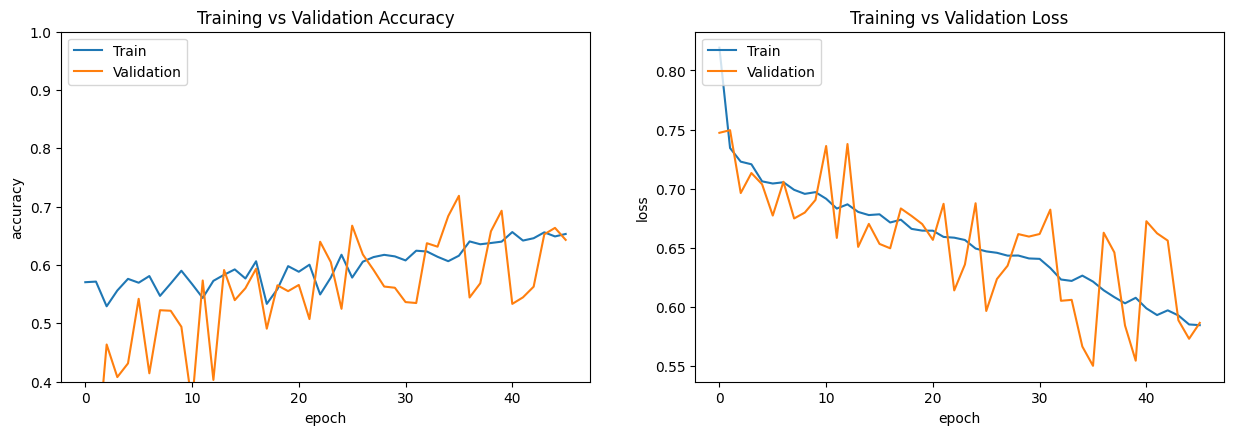

In [18]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

86/86 [==============================] - 56s 645ms/step


Text(50.722222222222214, 0.5, 'Real')

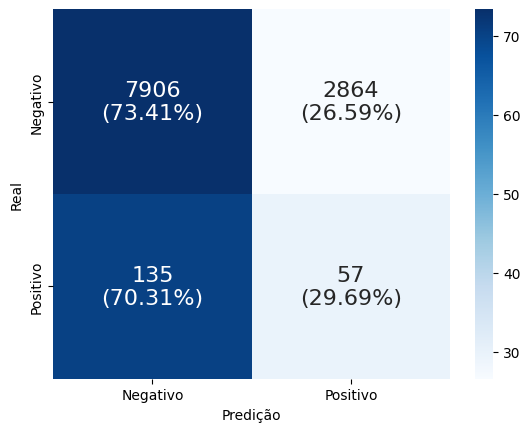

In [19]:
model_resnet50 = load_model('/content/drive/My Drive/inf0619_trabalho_final/producao/baseline_resnet50.h5')

pred_resnet50 = model_resnet50.predict(test_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)
cm_pct = confusion_matrix(y_true, y_pred_resnet50, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

Text(50.722222222222214, 0.5, 'Real')

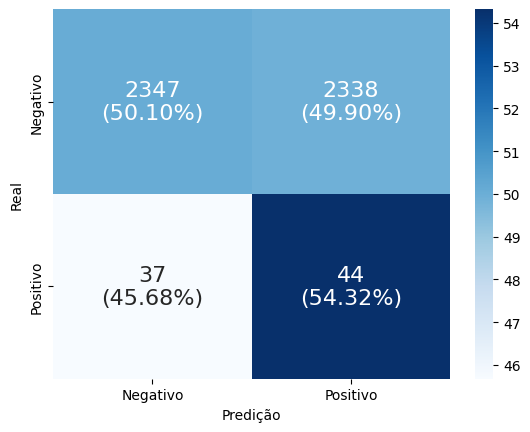

In [22]:
df_test_generator = pd.DataFrame(test_generator.filenames, columns=["img_path"])
df_test_generator["img_path"] = df_test_generator["img_path"].str.split("/", expand=True)[1]
df_test_generator = pd.merge(df_test_generator, pd.merge(df_test[["patient_id", "laterality"]], df_test["img_path"].str.split("/", expand=True)[[7]].rename(columns={7:"img_path"}), how='inner',left_index=True, right_index=True), how='inner', on='img_path')
df_test_generator = pd.merge(df_test_generator, df_test.groupby(["patient_id", "laterality"]).agg(cancer_true=("cancer","max")).reset_index(), how='inner', on=["patient_id", "laterality"])
df_test_generator = pd.merge(df_test_generator, pd.DataFrame(y_pred_resnet50, columns=["cancer_pred"]), how='inner', left_index=True, right_index=True)
df_test_generator = df_test_generator.groupby(["patient_id","laterality"]).agg(cancer_true=("cancer_true", "max"), cancer_pred=("cancer_pred", "max")).reset_index()
df_test_generator["patient_lat_id"] = df_test_generator["patient_id"].astype(str) + "_" + df_test_generator["laterality"]

cm = confusion_matrix(df_test_generator["cancer_true"].values , df_test_generator["cancer_pred"].values)
cm_pct = confusion_matrix(df_test_generator["cancer_true"].values, df_test_generator["cancer_pred"].values, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

In [23]:
df_test_generator

,patient_id,laterality,cancer_true,cancer_pred,patient_lat_id
0,5,L,0,0,5_L
1,5,R,0,1,5_R
2,30,L,0,0,30_L
3,30,R,0,1,30_R
4,65,L,0,1,65_L
...,...,...,...,...,...
4761,65477,R,0,0,65477_R
4762,65492,L,1,1,65492_L
4763,65492,R,0,1,65492_R
4764,65530,L,0,0,65530_L
